In [143]:
import sqlite3
import sys

In [156]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import contextily as cx

In [142]:
%load_ext autoreload
%autoreload 2

In [144]:
sys.path.append("..")

In [145]:
from src.trajectory import Trajectory

In [3]:
db_path = r"..\data\raw\rdb1\trajectories_rdb1_v3.sqlite"

In [4]:
con = sqlite3.connect(db_path)

In [5]:
cursor = con.cursor()

Tables in the sqlite DB:

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [r[0] for r in cursor.fetchall()]
print(tables)

In [ ]:
pd.read_sql('SELECT * FROM rdb1_1', con)

In [ ]:
df_list = list()
for t in tables:
    df_t = pd.read_sql(f'SELECT * FROM {t:s}', con)
    df_list.append(df_t)
    
df = pd.concat(df_list)

In [ ]:
del df["TRAILER_ID"] 

In [ ]:
df = df.reset_index()

In [ ]:
df.info()

In [7]:
output_path = "../data/raw/rdb1.parquet"

In [ ]:
df.to_parquet(output_path)

In [8]:
df = pd.read_parquet(output_path)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19174608 entries, 0 to 19174607
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   index      int64  
 1   ID         int64  
 2   TIMESTAMP  float64
 3   OBJID      int64  
 4   UTM_X      float64
 5   UTM_Y      float64
 6   UTM_ANGLE  float64
 7   V          float64
 8   ACC        float64
 9   ACC_LAT    float64
 10  ACC_TAN    float64
 11  CLASS      object 
 12  WIDTH      float64
 13  LENGTH     float64
 14  _V_kmh     float64
dtypes: float64(11), int64(3), object(1)
memory usage: 2.1+ GB


In [26]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,_V_kmh
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,17.064
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,17.100
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,17.100
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,17.100
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,17.136


# Explore data

In [9]:
print("Number of traffic participants:", df["OBJID"].nunique())

Number of traffic participants: 32873


In [10]:
print(df.groupby("OBJID").agg({"CLASS": "first"})["CLASS"].value_counts())

Car               26879
Medium Vehicle     2630
Pedestrian          963
Bicycle             831
Bus                 551
Trailer             529
Heavy Vehicle       347
Motorcycle          143
Name: CLASS, dtype: int64


## Sample rate

In [36]:
obj1_df = df.query("OBJID==1").sort_values("TIMESTAMP")

In [37]:
obj1_df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,_V_kmh
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,17.064
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,17.100
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,17.100
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,17.100
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,17.136


Text(0.5, 0, 'time [s]')

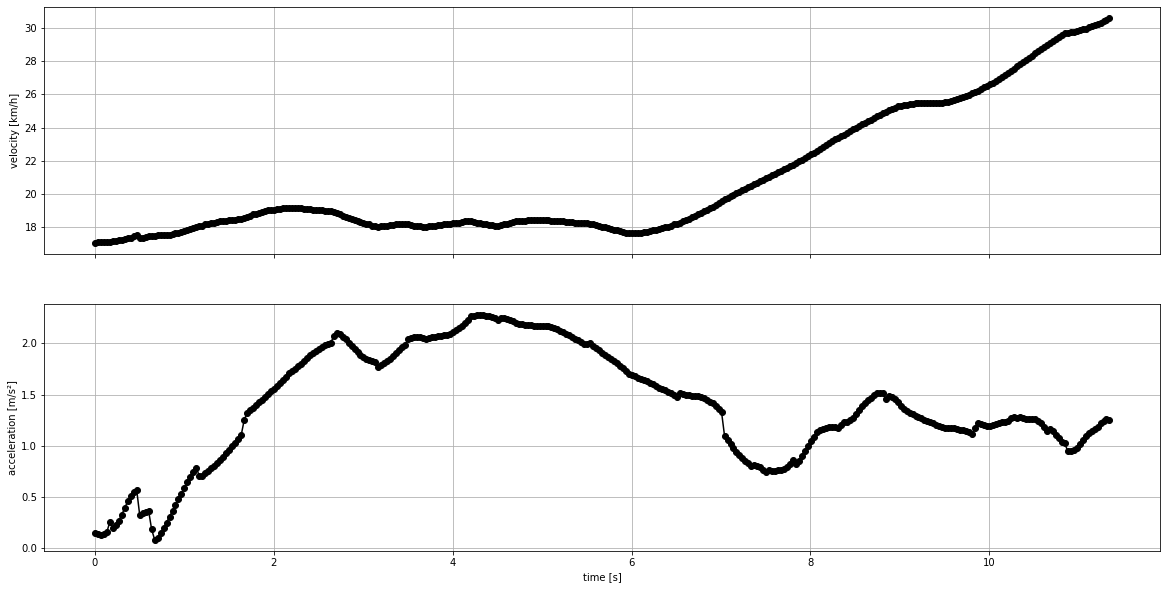

In [56]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)
axv, axa = axs
axv.plot(obj1_df["TIMESTAMP"], obj1_df["_V_kmh"], "ko-")
axa.plot(obj1_df["TIMESTAMP"], obj1_df["ACC"], "ko-")

axv.set_ylabel("velocity [km/h]")
axv.grid()

axa.set_ylabel("acceleration [m/s²]")
axa.grid()

axs[-1].set_xlabel("time [s]")


In [48]:
delta_t_ms = np.diff(obj1_df["TIMESTAMP"].values*1000)

In [49]:
delta_t_ms.min(), delta_t_ms.max()

(33.36599999999817, 33.36700000000019)

In [54]:
dr = stats.describe(delta_t_ms)
dr

DescribeResult(nobs=340, minmax=(33.36599999999817, 33.36700000000019), mean=33.36666764705882, variance=2.225490195580104e-07, skewness=-0.7117913418411341, kurtosis=-1.4933530856698929)

In [58]:
def mean_sample_frequency(values):
    return 1/np.diff(values).mean()

In [62]:
df.groupby("OBJID").agg({"TIMESTAMP": mean_sample_frequency}).rename(columns={'TIMESTAMP': 'frequency'}).describe()

,frequency
count,32873.000000
mean,29.970030
std,0.000003
min,29.969910
25%,29.970030
50%,29.970030
75%,29.970030
max,29.970090


Looks like the objects are sampled with **30 Hz**.

## Velocity and acceleration distributions per class

In [11]:
df["_V_kmh"] = df["V"]*3.6

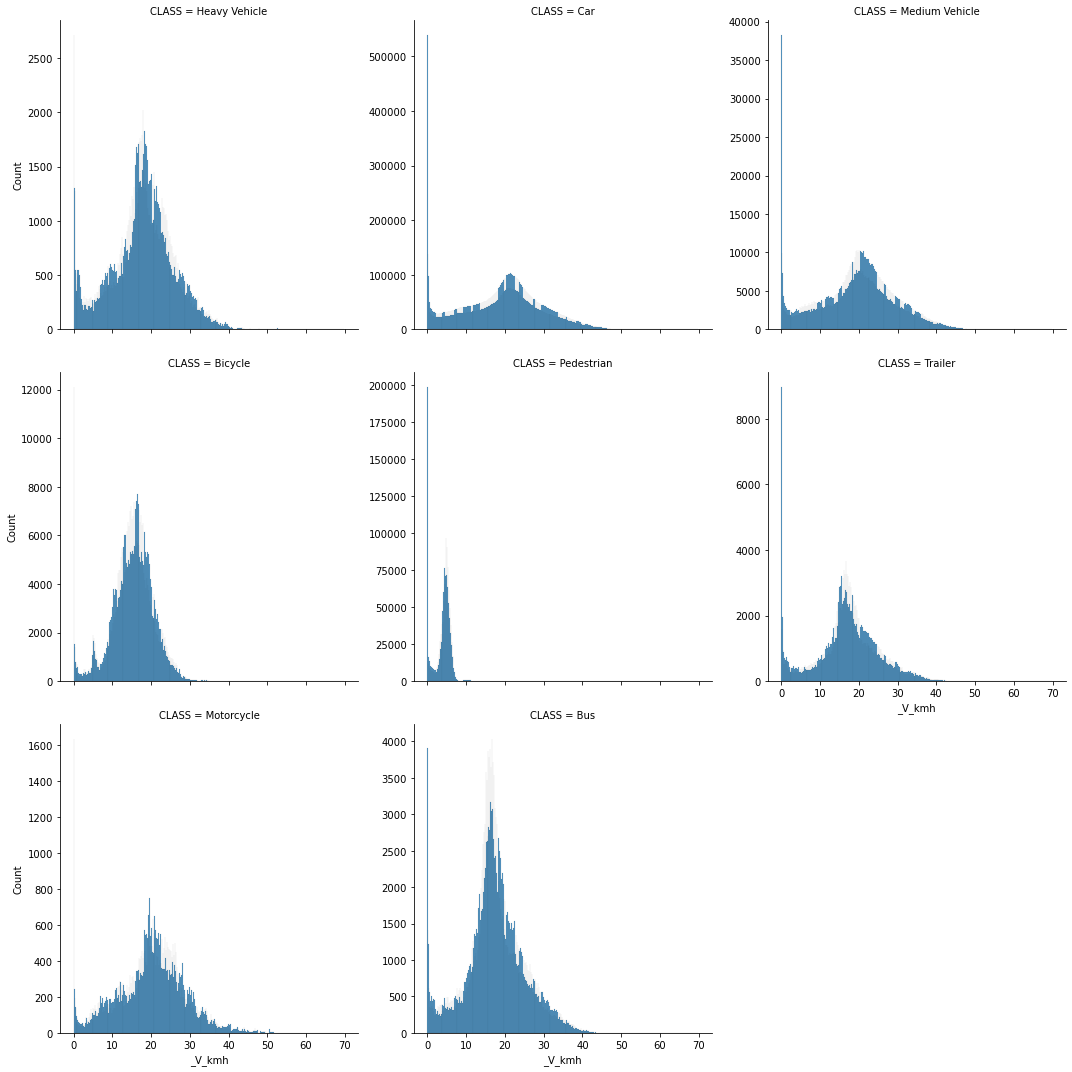

In [19]:
fg = sns.displot(df, x="_V_kmh", col="CLASS", col_wrap=3, facet_kws=dict(sharey=False))

In [21]:
df["ACC_TAN"].describe()

count    1.917461e+07
mean     1.610375e-01
std      7.595011e-01
min     -7.998650e+01
25%     -1.668000e-01
50%      9.240000e-02
75%      5.987000e-01
max      8.160790e+01
Name: ACC_TAN, dtype: float64

Text(0.5, 0.98, 'Cumulative distribution of acceleration samples')

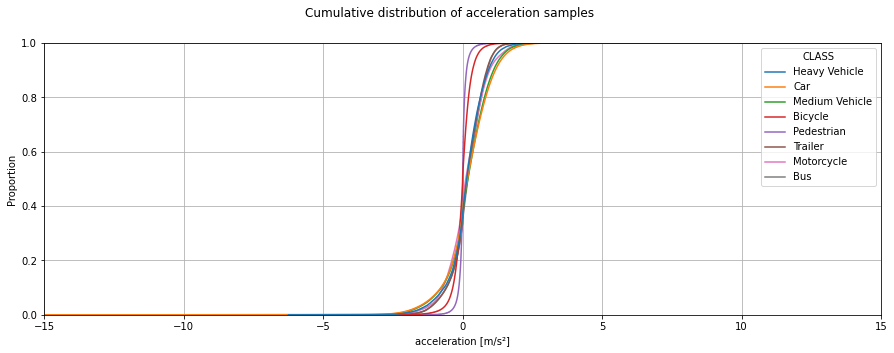

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.ecdfplot(df, x="ACC_TAN", hue="CLASS", ax=ax)
ax.set_xlim(-15, 15)
ax.set_xlabel("acceleration [m/s²]")
ax.grid()
fig.suptitle("Cumulative distribution of acceleration samples")

## Braking maneuvers

Get object IDs of trajectories with high decelleration

In [137]:
ids = df[df['ACC_TAN'].between(-15, -7)]["OBJID"].unique()
print(f"Found {len(ids)} objects!")

Found 21 objects!


Text(0.5, 0, 'time [s]')

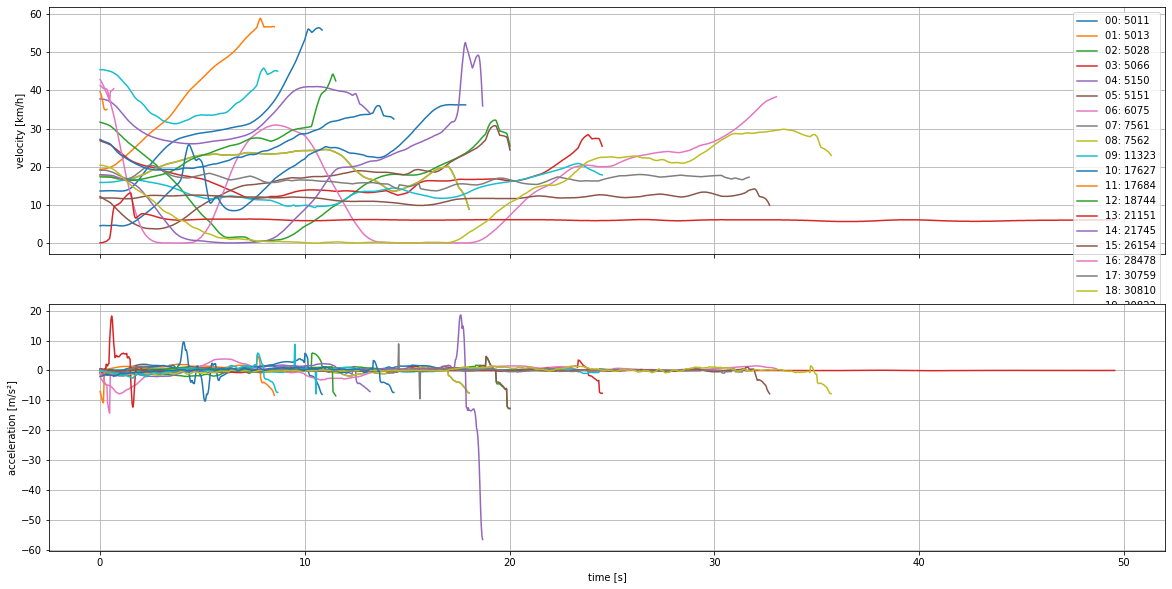

In [138]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)
axv, axa = axs

for i, objid in enumerate(ids):
    obj_df = df.query(f"OBJID=={objid}").sort_values("TIMESTAMP")
    
    obj_df["_t"] = obj_df["TIMESTAMP"] - obj_df["TIMESTAMP"].min()
    
    axv.plot(obj_df["_t"], obj_df["_V_kmh"], label=f"{i:02d}: {objid:03d}")
    axa.plot(obj_df["_t"], obj_df["ACC_TAN"])

axv.set_ylabel("velocity [km/h]")
axv.grid()
axv.legend()

axa.set_ylabel("acceleration [m/s²]")
axa.grid()

axs[-1].set_xlabel("time [s]")

In [139]:
obj_df = df.query(f"OBJID=={ids[5]}").sort_values("TIMESTAMP")

In [168]:
trajectory = Trajectory(obj_df["TIMESTAMP"], obj_df["UTM_X"], obj_df["UTM_Y"])

In [179]:
traj_gdf = trajectory.to_geopandas()
traj_gdf = traj_gdf.to_crs("EPSG:4326")

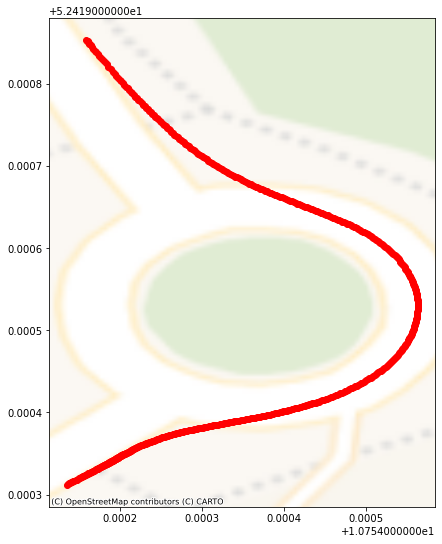

In [181]:
ax = traj_gdf.plot(color="red", figsize=(9, 9))
cx.add_basemap(ax, crs=traj_gdf.crs.to_string(),  source=cx.providers.CartoDB.Voyager, zoom=18)

In [140]:
obj_df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,_V_kmh
3432569,104607,104608,402.402000,5151,619289.23,5809124.31,0.692885,3.39,1.1179,0.0801,-1.1150,Bus,3.1727,12.076,12.204
3432570,104608,104609,402.435367,5151,619289.31,5809124.38,0.693885,3.36,1.2091,0.0844,-1.2061,Bus,3.1727,12.076,12.096
3432571,104609,104610,402.468733,5151,619289.40,5809124.46,0.694785,3.33,1.2669,0.0867,-1.2640,Bus,3.1727,12.076,11.988
3432572,104610,104611,402.502100,5151,619289.49,5809124.54,0.695785,3.30,1.2967,0.0876,-1.2938,Bus,3.1727,12.076,11.880
3432573,104611,104612,402.535467,5151,619289.58,5809124.62,0.696685,3.26,1.3021,0.0867,-1.2993,Bus,3.1727,12.076,11.736


Text(0.5, 0, 'time [s]')

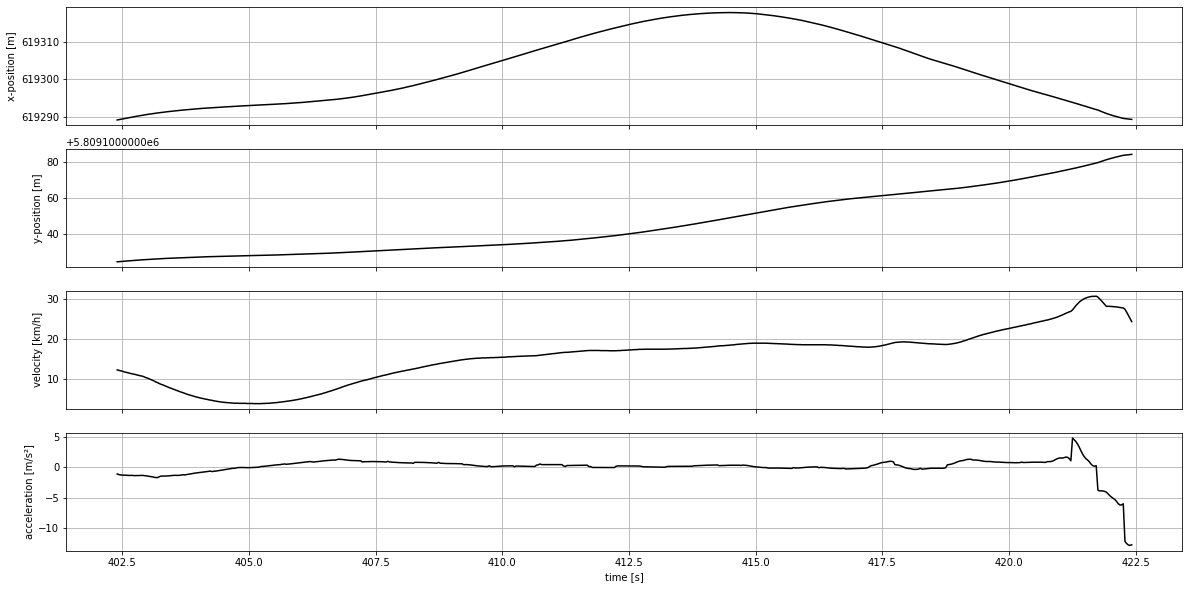

In [141]:
fig, axs = plt.subplots(nrows=4, figsize=(20, 10), sharex=True)

axx, axy, axv, axa = axs

axx.plot(obj_df["TIMESTAMP"], obj_df["UTM_X"], "k-")
axy.plot(obj_df["TIMESTAMP"], obj_df["UTM_Y"], "k-")

axv.plot(obj_df["TIMESTAMP"], obj_df["_V_kmh"], "k-")
axa.plot(obj_df["TIMESTAMP"], obj_df["ACC_TAN"], "k-")

axx.set_ylabel("x-position [m]")
axx.grid()

axy.set_ylabel("y-position [m]")
axy.grid()

axv.set_ylabel("velocity [km/h]")
axv.grid()

axa.set_ylabel("acceleration [m/s²]")
axa.grid()

axs[-1].set_xlabel("time [s]")